
# 신경망의 순전파

### _Objective_
1. **Feedforward Network**: Feedforward Network가 무엇인지 알아봅니다.<br>
2. **Feedforward with Keras**: Keras를 사용해 feedforward 모델을 모델링해봅니다.<br>
3. **Feedforward with Numpy**: Numpy를 사용해 간단하게 순전파 수식을 구현해 봅니다.<br>

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file

# \[ 1. Feedforward Network \]

순전파(Feedforward)란 신경망에서 입력층부터 출력층까지 각 층을 거쳐가며 신호가 타고넘어가는 일련의 과정을 뜻합니다. 입력층부터 출력층까지 앞에서 뒤로 신호가 타고 넘어가 '순전파'라는 이름이 붙었습니다. Keras와 Numpy를 이용해 구현해보겠습니다. <br>
* x -> y : 계산하는 방식 = 모델의 활용
* x <- y : 손실함수를 통해 각 층의 grdient를 업데이트 하는 방식 = 모델을 학습

## 1. 유닛 단위의 순전파 연산

순전파에서 유닛의 연산은 아래의 두 단계로 이루어져 있습니다. 각층에서 입력값을 수합하는 로짓과, 해당 로짓값에 따라 어떠한 시그널을 반환할지 결정하는 활성화 함수로 나누어져 있습니다.<br>

1. 로짓(z)를 계산하는 부분 : <br>
$
z = w_0 + w_1x_1 + w_2x_2 + w_3x_3\\
$

2. 활성화 함수($\sigma$)를 거치는 부분 : <br>
$a = \sigma(z) = \frac{1}{1+e^{-z}}$

<img src="https://i.imgur.com/26G8oSL.png" width="600" height="450"/>



## 2. 층 단위의 순전파 연산


$$x=\left[\begin{array}{rrr} 
x_1 \\
x_2 \\
x_3 
\end{array}\right]$$

입력층과 은닉층(유닛 수, 활성화 함수 등)을 설정하는 방법을 살펴보았습니다. 그럼 이제 아래와 같이 생긴 2층 신경망을 처음부터 끝까지 구현하는 코드를 살펴봅시다.  

<img src="https://i.imgur.com/T9jkFuv.png" width="600" height="450"/><br>

$$
z1 = X\cdot W1 + b1 \\
a1 = \sigma(z1) \\
z2 = a1 \cdot W2 + b2 \\
\hat y = \sigma(z2)
$$

# \[ 2. Keras로 Feedforward Network 구현하기 \]

### 예제 데이터 ) 암 환자 데이터 셋

나이와 종양크기를 바탕으로 암 환자의 종양이 양성인지 음성인지를 분류하는 데이터셋입니다.

In [5]:
fpath = get_file("cancer_dataset.csv",
                 "https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/cancer_dataset.csv")
cancer_df = pd.read_csv(fpath)
X = cancer_df[['age','tumor_size']]
y = cancer_df["label"]

X = (X - X.min()) / (X.max() - X.min())

cancer_df.head()

,age,tumor_size,label
0,2.170865,3.087710,0.0
1,8.000731,5.237815,1.0
2,5.248661,5.851058,1.0
3,3.433496,4.278379,0.0
4,2.365321,3.508396,0.0


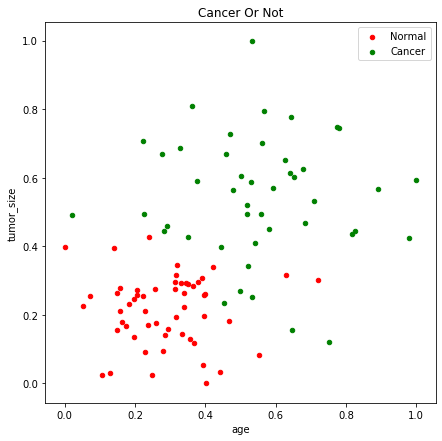

In [6]:
### 데이터 시각화
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)

# 0: 정상
X[y==0].plot('age','tumor_size',ax=ax,legend=True,
                           kind='scatter',color='red')
# 1: 암환자
X[y==1].plot('age','tumor_size',ax=ax,legend=True,
                           kind='scatter',color='green')
plt.legend(['Normal','Cancer'])
plt.title("Cancer Or Not")
plt.show()

### (1) Input 설정하기

신경망의 Input Layer에 넣을 입력 신호를 설정하기 위해 keras에서는 `keras.layers.Input` API를 지원합니다.

In [7]:
from tensorflow.keras.layers import Input

위 예제 데이터에서 입력 데이터 `X`는 나이(age)와 종양의 크기(tumor_size)로 구성됩니다. X가 2 가지이므로, 입력층의 shape은 `(2,)`으로 설정하여 `Input(shape=(2,), name='x')`로 입력층을 생성합니다.

In [10]:
# 입력층
inputs = Input(shape=(2,), name='x') # 나이, 종양의 크기
display(inputs)
# shape=(None, 2) = 병렬적으로 몇 개가 들어올지 몰라서 None임

<tf.Tensor 'x_2:0' shape=(None, 2) dtype=float32>

그런데 `display(inputs)`로 입력층의 내용을 출력해보면 `shape=(None, 2)`라고 확인됩니다. 여기서 None은 무슨 의미일까요? 

이전 Section에서 말했듯이 keras에서는 첫번째 축이 Batch 축으로 세팅되어 있으며, 따로 설정해 주지 않으면 None을 반환합니다. 위 예제에서 Batch 축을 따로 세팅하지 않았으므로, 입력층의 shape이 `(None,2)`가 됨을 볼 수 있습니다. 

데이터를 하나로 묶은 입력 데이터를 **배치(Batch)**라고 하는데, None은 입력한 데이터 전체를 하나로 묶어 처리한다는 뜻입니다. 위 예제에서는 batch를 따로 설정하지 않았기 때문에 100명 분의 데이터가 전부 한 번에 처리가 될 것입니다. batch를 10, 50 등으로 설정하면 10명, 50명 분의 데이터가 하나의 batch로 묶여서 돌아가게 됩니다.

배치 처리를 수행함으로써 컴퓨터는 큰 배열로 이루어진 계산을 하게 되는데, 컴퓨터에서는 큰 배열을 한꺼번에 계산하는 것이 분할된 작은 배열을 여러 번 계산하는 것보다 빠릅니다. 덕분에 배치 처리를 하게 되면, 환자 한 명의 정보를 처리하는 것보다, 환자 한 명당 처리 시간이 대폭 줄어드는 이득을 얻을 수 있습니다.

### (2) 가중치(weight)와 편향(bias) 생성하기

입력층이 설정되었습니다. 앞서 예로 든 것처럼 10개 유닛으로 구성된 1번 층을 만들어 2층 신경망을 구성하게 되면, 학습해야 하는 가중치와 편향에는 ($w_1$,$b_1$,$w_2$,$b_2$) 등이 있습니다. keras에서는 가중치를 계산하며 층을 쌓을 때는 `keras.layers.Dense` API를 이용합니다.

In [11]:
from tensorflow.keras.layers import Dense
dense1 = Dense(units=10)
dense1(inputs)

<tf.Tensor 'dense/Identity:0' shape=(None, 10) dtype=float32>

dense1의 가중치 $w_1$와 편향$b_1$가 어떤 형태인지 확인해봅시다. 

In [18]:
print("input shape : ",inputs.shape)
#### [[x_1,x_2],[x_1,x_2],[x_1,x_2],...,[x_1,x_2]]
print("")

W, b = dense1.get_weights() # W와 b로 되어있다.
print(f"W >>> shape  : {W.shape}")
display(W)

print(f"b >>> shape  : {b.shape}")
display(b) # broadcasing으로 (None, 10)이 됨. 결국 y는 (None, 10)

input shape :  (None, 2)

W >>> shape  : (2, 10)


array([[ 0.04098374,  0.17554092, -0.20379364,  0.0783987 ,  0.5352687 ,
        -0.3559753 , -0.19818056, -0.25032142, -0.33734876,  0.06285697],
       [-0.2717214 ,  0.05923641, -0.3021516 , -0.12542534, -0.638752  ,
        -0.10704118, -0.16285187, -0.5131426 ,  0.5852068 , -0.54033357]],
      dtype=float32)

b >>> shape  : (10,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

위 내용을 보면, 입력 데이터의 크기에 맞게 자동으로 가중치(`W`와 `b`)가 생성되어 있음을 알 수 있습니다.<br>
입력 데이터에 피쳐가 2가지이고 유닛은 10개이므로, $w_1$는 (2, 10) 형태를 가지게 되었으며, $b_1$은 (10,)의 형태를 가지게 되었습니다. 

10개의 유닛으로 구성된 1번째 층이 생성되었으니, 입력신호를 `dense1`층에 통과시켜 보겠습니다.

In [19]:
dense1_out = dense1(inputs)
dense1_out

<tf.Tensor 'dense_1/Identity:0' shape=(None, 10) dtype=float32>

이렇게 1번째 층을 통과하여 얻어진`dense1_out1`은 활성화 함수의 입력값이 될 것입니다. 

### (3) 활성화 함수 적용하기

활성화 함수로 딥러닝에서 가장 많이 쓰이는 `relu`함수를 이용해 입력 신호의 총합을 출력 신호로 변환하겠습니다. ReLU 함수란 아래와 같습니다.

$$
RELU(x) = \begin{cases} 
x && \mbox{if x } \ge 0 \\
0 && \mbox{if x } < 0 \\
\end{cases}
$$


0보다 작은 값을 받으면 0을 반환하고, 0보다 크거나 같은 값을 받으면 입력 값을 그대로 반환하는 형태입니다.

앞서 `dense1`을 통과하여 얻은 `dense1_out`을 `relu`에 입력하면 0 또는`x`로 변환된 `relu_out`을 얻을 수 있습니다.

In [20]:
from tensorflow.keras.activations import relu, sigmoid
relu1_out = relu(dense1_out)
relu1_out

<tf.Tensor 'Relu:0' shape=(None, 10) dtype=float32>

실제 신경망을 구성할 때는 층을 구성할 때 `activation`이라는 인자를 이용해 활성화 함수를 설정할 수 있습니다. 가령 1번째 층에서 유닛을 10개로 설정하고, 활성화 함수는 `relu`로 설정하려면 아래와 같이 설정하면 됩니다.

In [22]:
dense1 = Dense(10,activation='relu', name='hidden')
dense1_output = dense1(inputs)

### (4) 2층 신경망 구현하기

입력층과 은닉층(유닛 수, 활성화 함수 등)을 설정하는 방법을 살펴보았습니다. 그럼 이제 아래와 같이 생긴 2층 신경망을 처음부터 끝까지 구현하는 코드를 살펴봅시다.  

<img src="https://i.imgur.com/T9jkFuv.png" width="600" height="450"/><br>

$$
z1 = X\cdot W1 + b1 \\
a1 = \sigma(z1) \\
z2 = a1 \cdot W2 + b2 \\
\hat y = \sigma(z2)
$$

keras에서는 keras의 함수형 API를 사용할 때, input과 output을 지정해주면 신경망의 흐름대로 모델을 생성하는 `keras.models.Model` API를 지원합니다. `Model`에 입력층과 출력층을 인자로 입력하면 신경망 모델이 생성됩니다.

In [25]:
from tensorflow.keras.models import Model

# 신경망 구현
inputs = Input(2,name='x')

dense1 = Dense(10,activation='relu', name='hidden')
dense1_output = dense1(inputs)

dense2 = Dense(1,activation='sigmoid', name='output')
output = dense2(dense1_output)

# 신경망 모델 생성
model = Model(inputs, output, name='train')
model.summary()

Model: "train"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               [(None, 2)]               0         
_________________________________________________________________
hidden (Dense)               (None, 10)                30        
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


### (5) 신경망에 대한 정보 확인하기

keras에서는 `summary()`함수를 활용해 현재 생성된 모델에 대한 정보를 확인할 수 있습니다.

In [14]:
model.summary()

Model: "train"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               [(None, 2)]               0         
_________________________________________________________________
hidden (Dense)               (None, 10)                30        
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


### (6) 모델 사용하기

keras에서는 `model.predict(input_sample)`를 통해 입력값(input_sample)`X`가 model을 통과했을 때의 예측값(ouput prediction)을 얻을 수 있습니다. 여기서 얻은 예측값은 아직 최선의 가중치를 찾지 않은 초기 가중치 값을 통해 얻은 값이므로 오차율은 높을 수 있습니다.

In [26]:
model.predict(X) # 순전파

array([[0.49377936],
       [0.45281193],
       [0.47851723],
       [0.4882324 ],
       [0.49322692],
       [0.45525783],
       [0.49031642],
       [0.47572947],
       [0.49436378],
       [0.473603  ],
       [0.48544824],
       [0.48409113],
       [0.47965798],
       [0.48031965],
       [0.4876397 ],
       [0.44597226],
       [0.47531497],
       [0.46777552],
       [0.48555052],
       [0.4800219 ],
       [0.49208868],
       [0.4860423 ],
       [0.47755522],
       [0.48263136],
       [0.46455917],
       [0.4697573 ],
       [0.47870925],
       [0.49364614],
       [0.47588816],
       [0.44467798],
       [0.4806331 ],
       [0.48792785],
       [0.49275467],
       [0.47355253],
       [0.48976198],
       [0.46033838],
       [0.4858888 ],
       [0.48093635],
       [0.46831688],
       [0.477105  ],
       [0.47163087],
       [0.4863549 ],
       [0.49328196],
       [0.48085263],
       [0.48368496],
       [0.46508667],
       [0.48899037],
       [0.492

In [28]:
model.predict(X).shape

(100, 1)

# \[ 3. Numpy를 이용해 순전파 과정 진행하기 \]

Keras로 구현한 순전파 네트워크가 잘 돌아가는지, Keras에서 얻은 가중치 값을 가져와 Numpy 코드로 직접 수식을 구현하여 단계별로 얻어지는 값을 확인하고, 예측 결과 값을 비교해보겠습니다. 앞서 사용한 암환자 데이터셋을 이용해보겠습니다.

### (1) 가중치 가져오기

keras에서는 `model.get_layer('layer_name').get_weights()`을 통해 모델 내 원하는 층의 가중치 값을 가져올 수 있습니다. 이는 class 또는 instance의 이동으로 다른 구조에서 가중치 값을 간단하게 공유할 수 있다는 점은 keras의 장점 중 하나입니다.

In [32]:
W1, B1 = model.get_layer('hidden').get_weights()
W2, B2 = model.get_layer('output').get_weights()

np.set_printoptions(3)
print("W1 >>>")
display(W1)
print("B1 >>>")
display(B1)
print("W2 >>>")
display(W2)
print("B2 >>>")
display(B2)

W1 >>>


array([[-0.046, -0.277,  0.33 ,  0.506, -0.105,  0.473, -0.158,  0.404,
        -0.204, -0.455],
       [ 0.387,  0.52 ,  0.452,  0.5  ,  0.633, -0.344, -0.612,  0.356,
         0.188, -0.194]], dtype=float32)

B1 >>>


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

W2 >>>


array([[-0.34 ],
       [-0.001],
       [ 0.382],
       [-0.297],
       [ 0.27 ],
       [-0.443],
       [ 0.54 ],
       [-0.169],
       [-0.554],
       [ 0.005]], dtype=float32)

B2 >>>


array([0.], dtype=float32)

### (2) 순전파 수식 구현
첫번째 층을 통과하는 과정을 살펴봅시다.

<img src="https://i.imgur.com/o1SgBJZ.png" width="600" height="450"/><br>

위에 도식에서 입력 데이터 X가 가중치와 곱해진 결과값을 얻는 과정을 수식으로 나타내면 다음과 같습니다.

$
Z_1 = X \cdot W_1 + B_1
$

이를 numpy 식으로 구현하면 아래와 같이 됩니다. 

두가지 연산
* 수확해지는 로짓 연산
* 활성화 함수 연산

In [41]:
X = cancer_df[['age','tumor_size']].values
hidden1 = np.dot(X, W1) + B1
hidden1.shape # (100, 10)
# hidden1

(100, 10)

### (3) 활성화 함수 적용
이렇게 입력값에 가중치를 곱해 얻은 $Z_1$, 즉`hidden1`에 `relu`활성화 함수를 적용해 보겠습니다.

<img src="https://i.imgur.com/QVfBn7d.png" width="600" height="450"/><br>

$a_1 = RELU(z_1)$


이를 numpy 식으로 구현하면 아래와 같이 됩니다. 

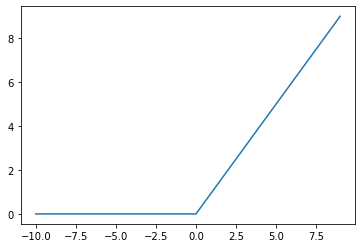

In [46]:
import numpy as np
def relu(x):
    if x>= 0:
        return x
    else:
        return 0
xs = np.arange(-10,10,1)
plt.plot(xs,[relu(x) for x in xs])

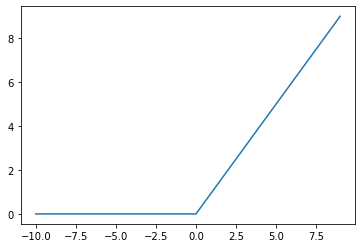

In [47]:
def relu(x):
    return np.maximum(x,0)

xs = np.arange(-10,10,1)
plt.plot(xs,[relu(x) for x in xs])

In [50]:
hidden1_np_output = np.maximum(hidden1,0)
# hidden1_np_output
hidden1_np_output = relu(hidden1)
hidden1_np_output

array([[1.094e+00, 1.005e+00, 2.112e+00, 2.644e+00, 1.728e+00, 0.000e+00,
        0.000e+00, 1.976e+00, 1.377e-01, 0.000e+00],
       [1.655e+00, 5.099e-01, 5.007e+00, 6.671e+00, 2.477e+00, 1.984e+00,
        0.000e+00, 5.095e+00, 0.000e+00, 0.000e+00],
       [2.020e+00, 1.591e+00, 4.377e+00, 5.584e+00, 3.155e+00, 4.715e-01,
        0.000e+00, 4.203e+00, 2.909e-02, 0.000e+00],
       [1.496e+00, 1.275e+00, 3.067e+00, 3.879e+00, 2.349e+00, 1.535e-01,
        0.000e+00, 2.910e+00, 1.039e-01, 0.000e+00],
       [1.247e+00, 1.171e+00, 2.367e+00, 2.953e+00, 1.974e+00, 0.000e+00,
        0.000e+00, 2.204e+00, 1.772e-01, 0.000e+00],
       [5.845e-01, 0.000e+00, 3.153e+00, 4.398e+00, 7.705e-01, 2.258e+00,
        0.000e+00, 3.410e+00, 0.000e+00, 0.000e+00],
       [9.895e-01, 7.775e-01, 2.148e+00, 2.741e+00, 1.545e+00, 2.350e-01,
        0.000e+00, 2.063e+00, 1.257e-02, 0.000e+00],
       [2.298e+00, 1.822e+00, 4.961e+00, 6.325e+00, 3.592e+00, 5.142e-01,
        0.000e+00, 4.759e+00, 4.252e-

### (4) 순전파 수식 구현
두번째 layer를 통과하는 과정입니다.

<img src="https://i.imgur.com/WKOjOg6.png" width="600" height="450"/><br>

첫 번째 층을 통과한 결과 값을 입력 값으로 받아 가중치 $W_2$와 곱하고, 편향 $b_2$를 더합니다. 

In [53]:
output_z = np.dot(hidden1_np_output, W2) + B2
# output_z

### (5) 활성화 함수 적용
최종적으로 두 번째 층의 결과값을 내기 위해 `output_z`에 `sigmoid`활성화 함수를 적용해 보겠습니다.
<img src="https://i.imgur.com/9AceY76.png" width="600" height="450"/><br>

In [54]:
np_output = 1/(1+np.exp(-output_z))
np_output

array([[0.427],
       [0.154],
       [0.32 ],
       [0.384],
       [0.417],
       [0.159],
       [0.408],
       [0.299],
       [0.426],
       [0.274],
       [0.371],
       [0.324],
       [0.323],
       [0.29 ],
       [0.358],
       [0.117],
       [0.298],
       [0.249],
       [0.362],
       [0.328],
       [0.416],
       [0.376],
       [0.302],
       [0.311],
       [0.221],
       [0.231],
       [0.314],
       [0.418],
       [0.253],
       [0.122],
       [0.336],
       [0.387],
       [0.426],
       [0.281],
       [0.401],
       [0.181],
       [0.341],
       [0.326],
       [0.251],
       [0.296],
       [0.25 ],
       [0.373],
       [0.414],
       [0.318],
       [0.32 ],
       [0.227],
       [0.371],
       [0.422],
       [0.205],
       [0.249],
       [0.357],
       [0.34 ],
       [0.326],
       [0.354],
       [0.295],
       [0.101],
       [0.317],
       [0.26 ],
       [0.295],
       [0.279],
       [0.162],
       [0.22 ],
       [

### (6) keras 결과와 비교하기

numpy에서 제공하는 testing 모듈을 통해 keras와 numpy를 이용해 만든 각각의 결과를 비교해보도록 하겠습니다. 아래 코드를 동작했을 때 아무 문제없이 작동하면 두 결과가 거의 일치하는 것이고, 그렇지 않다면 오류 메시지를 반환할 것입니다.

In [55]:
keras_output = model.predict(cancer_df[['age','tumor_size']])

# 아무값이 뜨지않으면 같다는 것을 의미한다. 
np.testing.assert_array_almost_equal(np_output, keras_output)

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/09/16


---